## Data Science for Algorthmmic Trading
### Part 1 : US/CAD 환율 데이터 전처리

- 참고자료 : https://towardsdatascience.com/data-science-in-algorithmic-trading-d21a46d1565d

<div style="text-align: right"> Initial upload: 2020.07.25 </div>
<div style="text-align: right"> Last update: 2020.07.25 </div>

여기서는 환율정보 분석에 대하여 설명한다. **위 참고자료의 내용을 번역, 필사하고, 일부 내용을 추가한 것이다.**   
환율은 영어로 exchange rate이다. 그런데 기준통화/대상통화(A/B) 형태로 표현할 때 Currency pair라고 부른다. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 20

### 1. 데이터 읽어오기  
- 여기서는 USD/CAD currency pair 데이터셋을 살펴본다.[[데이터주소]](https://open.canada.ca/data/en/dataset/1bc25b1e-0e02-4a5e-afd7-7b96d6728aac)

In [2]:
# meta = pd.read_csv('10100008_MetaData.csv')
rates = pd.read_csv('10100008.csv')

In [3]:
rates.head()

,REF_DATE,GEO,DGUID,Type of currency,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1950-10-02,Canada,NaN,"United States dollar, noon spot rate",Dollars,81,units,0,v121716,1.10,1.060000,NaN,NaN,NaN,8
1,1950-10-02,Canada,NaN,"Danish krone, noon spot rate",Dollars,81,units,0,v121743,1.40,0.153459,NaN,NaN,NaN,8
2,1950-10-02,Canada,NaN,"Norwegian krone, noon spot rate",Dollars,81,units,0,v121717,1.10,0.148400,NaN,NaN,NaN,8
3,1950-10-02,Canada,NaN,"Swedish krona, noon spot rate",Dollars,81,units,0,v121718,1.11,0.204800,NaN,NaN,NaN,8
4,1950-10-02,Canada,NaN,"Swiss franc, noon spot rate",Dollars,81,units,0,v121719,1.12,0.243400,NaN,NaN,NaN,8


In [4]:
rates.shape

(534282, 15)

### 2. 전처리

원하는 컬럼 지정하기 : 기준일과 환율

In [5]:
rate_cols = ['REF_DATE', 'VALUE']

기준통화만 추출하기 : USD

In [6]:
rates = rates[rates['Type of currency']=='United States dollar, closing spot rate']

원하는 컬럼을 추출하고 결측치를 처리

In [7]:
rates = rates[rate_cols]

In [8]:
rates.head()

,REF_DATE,VALUE
6,1950-10-02,1.05500
15,1950-10-03,1.05000
24,1950-10-04,1.05250
33,1950-10-05,1.06000
42,1950-10-06,1.05875


In [9]:
rates.isnull().sum()

REF_DATE      0
VALUE       628
dtype: int64

In [10]:
# 결측치에 일단 0을 대입
rates = rates.fillna(0)

In [11]:
rates.isnull().sum()

REF_DATE    0
VALUE       0
dtype: int64

기준일을 인덱스로 지정하기

In [12]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24316 entries, 6 to 534256
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   REF_DATE  24316 non-null  object 
 1   VALUE     24316 non-null  float64
dtypes: float64(1), object(1)
memory usage: 569.9+ KB


In [13]:
rates['REF_DATE'] = pd.to_datetime(rates['REF_DATE'])

In [14]:
rates.index = rates['REF_DATE']

In [15]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24316 entries, 1950-10-02 to 2017-04-28
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   REF_DATE  24316 non-null  datetime64[ns]
 1   VALUE     24316 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 569.9 KB


In [16]:
# rates = rates.drop('REF_DATE', axis = 1)

In [17]:
rates.head()

,REF_DATE,VALUE
REF_DATE,,
1950-10-02,1950-10-02,1.05500
1950-10-03,1950-10-03,1.05000
1950-10-04,1950-10-04,1.05250
1950-10-05,1950-10-05,1.06000
1950-10-06,1950-10-06,1.05875


컬럼명 변환

In [18]:
rates = rates.rename(columns={'VALUE':'USD_CAD'})

In [19]:
rates.head()

,REF_DATE,USD_CAD
REF_DATE,,
1950-10-02,1950-10-02,1.05500
1950-10-03,1950-10-03,1.05000
1950-10-04,1950-10-04,1.05250
1950-10-05,1950-10-05,1.06000
1950-10-06,1950-10-06,1.05875


0 값 특징 확인
- 0으로 표시된 날은 아마도 장이 열리지 않는 주말이나 공휴일이었을 가능성이 높다.
- 앞에서 결측치를 0으로 대체한 것을 포함해서 이런 값들은 직전 개장일의 값으로 대체한다.

In [20]:
rates['day of week'] = rates['REF_DATE'].dt.dayofweek

In [21]:
rates[(rates['day of week']==5) | (rates['day of week']==6)]

,REF_DATE,USD_CAD,day of week
REF_DATE,,,
1950-10-07,1950-10-07,0.0,5
1950-10-08,1950-10-08,0.0,6
1950-10-14,1950-10-14,0.0,5
1950-10-15,1950-10-15,0.0,6
1950-10-21,1950-10-21,0.0,5
...,...,...,...
2017-04-09,2017-04-09,0.0,6
2017-04-15,2017-04-15,0.0,5
2017-04-16,2017-04-16,0.0,6


- 이외에 공휴일로 인한 0도 있을 것이다.(공휴일을 찾는 함수를 로직을 생성해 봤지만 확인 할 수 없었다., 아래 참고)

In [22]:
# from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# pd.tseries.holiday.

# cal = calendar()
# holidays = cal.holidays(start=rates.index.min(), end=rates.index.max())

# rates['holiday'] = rates['REF_DATE'].isin(holidays)

# rates[rates['holiday']==True]

# !pip install holidays
# import holidays
# hday = holidays.CountryHoliday(country='CA', years=[np.int(rates.index.min().strftime('%Y')),
#                                                    np.int(rates.index.max().strftime('%Y'))],
#                               expand=False)

본격 적으로 0값 처리하기

In [23]:
while rates[rates['USD_CAD']==0].count(axis = 0)['USD_CAD']/len(rates.index) >0:
    # 0 값이 없어 질때 까지 진행
    print('Shifting rates. Days with rate at 0 = %', 
          rates[rates == 0].count(axis=0)['USD_CAD']/len(rates.index))
    rates['yesterday'] = rates['USD_CAD'].shift(1)
    rates['USD_CAD']  = np.where(rates['USD_CAD']==0, 
                                 rates['yesterday'], rates['USD_CAD'])
    
print("Days with rate at 0 = %",
      rates[rates == 0].count(axis=0)['USD_CAD']/len(rates.index))

Shifting rates. Days with rate at 0 = % 0.31139990129955586
Shifting rates. Days with rate at 0 = % 0.16404836321763447
Shifting rates. Days with rate at 0 = % 0.020603717716729725
Shifting rates. Days with rate at 0 = % 0.0020151340681033064
Days with rate at 0 = % 0.0


In [24]:
rates.head()

,REF_DATE,USD_CAD,day of week,yesterday
REF_DATE,,,,
1950-10-02,1950-10-02,1.05500,0,NaN
1950-10-03,1950-10-03,1.05000,1,1.0550
1950-10-04,1950-10-04,1.05250,2,1.0500
1950-10-05,1950-10-05,1.06000,3,1.0525
1950-10-06,1950-10-06,1.05875,4,1.0600


In [25]:
rates = rates.drop(['REF_DATE', 'day of week', 'yesterday'],
                  axis = 1)

### 3. 시각화

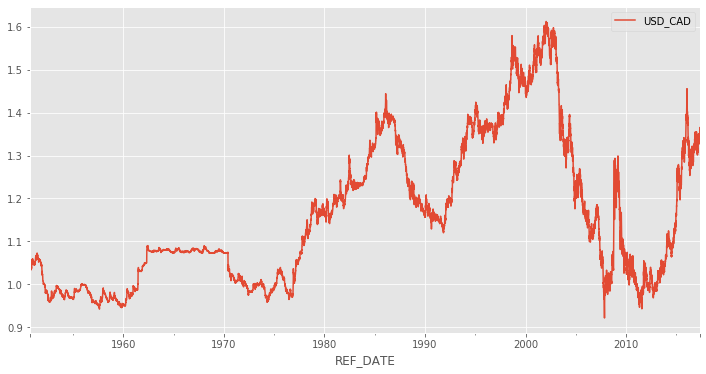

In [26]:
rates.plot(figsize = (12, 6))

<img src = 'pic/20200725.jpg' width="500" height="100" />

위 그림은 우리가 그린 것이고 아래는 fxtop.com 이라는 곳에서 추출한 것이다.

결과가 제대로 나온 것을 확인 할 수가 있다.

- 지금까지 USD/CAD 환율 변동을 plotting 하기 위해 전처리를 수행하였다.  
- 다음에는 환율을 예측하기 위해 Industrial ProductPrice Index(IPPI)를 살펴본다.